In [95]:
import collections
import random
import time

from math import cos, sin, sqrt

In [155]:
Gene           = collections.namedtuple('Gene', 'a e')
GeneDecoded    = collections.namedtuple('GeneDecoded', 'x y v al')
CartesianPoint = collections.namedtuple('CartesianPoint', 'x y')

In [181]:
class Subject():
    
    # codificação - u
    # dna = [Gene, ...]
    #     Gene = [a, e]
    #         a = float: aceleração
    #         e = float: variação angular


    # decodificação - x
    # dna_decoded = [GeneDecoded, ...]
    #     GeneDecoded = (x, y, v, al)
    #         x  = : Posição do VANT no eixo x (aka px)
    #         y  = : Posição do VANT no eixo y (aka py)
    #         v  = : Velocidade do VANT na horizontal
    #         al = : ângulo (direção) do VANT na horizontal
    
    # Mudanças na função __init__ podem impactar a função generate
    def __init__(
        self,
        px0=0,
        py0=0,
        v0=24,
        al0=90,
        v_min=11.1,
        v_max=30.5,
        e_min=-3,
        e_max=3,
        a_min=0.0,
        a_max=2.0,
        T=5,
        delta_T=1,
        delta=0.001,
        F=0,
        m=1,
        mutation_prob=0.7,
        mutation_rate=0.01,
        spawn_mode='random',
        alpha_BLX=0.1
    ):
        # VANT
        # px0   int : Posição inicial no eixo x (m)
        # py0   int : Posição inicial no eixo y (m)
        # v0    int : Velocidade Inicial (m/s)
        # al0   int : Ângulo inicial (graus)
        self.gene_decoded_0 = GeneDecoded(px0, py0, v0, al0) # GeneDecoded : objeto contendo o gene decodificado 0
        self.v_min = v_min # float : Velocidade máxima (m/s)
        self.v_max = v_max # float : Velocidade mínima (m/s)
        self.e_min = e_min # int   : Velocidade angular mínima (graus/s)
        self.e_max = e_max # int   : Velocidade angular máxima (graus/s)
        self.a_min = a_min # float : Aceleração mínima (m/s**2)
        self.a_max = a_max # float : Aceleração máxima (m/s**2)
        
        # Modelo
        self.T       = T       # int : Horizonte de planejamento (s)
        self.delta_T = delta_T # int : Discretização do tempo (s)
        self.delta   = delta   # float : Probabilidade de violar Phi_n (-)
        self.F       = F       # ? : Resistência do Ar ou Força de Arrasto #TODO: equação 3.5
        self.m       = m       # ? : Massa do VANT (!=0)
    
        # Parametros do indivíduo
        self.mutation_prob = mutation_prob # float : Probabilidade de ocorrer uma mutação no dna (%)
        self.mutation_rate = mutation_rate # float : Taxa de mutação no dna (%)
        self.fitness       = None          # float : Fitness do indivíduo
        self.dna           = None          # list  : Conjunto de genes formando o DNA ([Gene, ...])
        self.dna_decoded   = None          # list  : DNA decodificado ([GeneDecoded, ...])
        self.spawn_mode    = spawn_mode    # str   : Tipo de incialização do DNA {'random'}
        self.alpha_BLX     = alpha_BLX     # float : Parametro real constante, usado no crossover BLX alpha
        
        self.spawn(mode=spawn_mode)
    
    
    def set_fitness(self, fitness):
        self.fitness = fitness
        
    # ---
    
    def spawn(self, mode):
        self.dna = [self._build_gene(mode) for i in range(self.T) ]
        
    def _build_gene(self, mode='random'):
        # Inicialização aleatória gera valores com distribuição uniforme
        if mode == 'random':
            a = random.uniform(self.a_min, self.a_max)
            e = random.uniform(self.e_min, self.e_max)
            
        return Gene(a, e)
    
    # ---
    
    def decode(self):
        #self.dna_decoded = [self._decode_gene() for i in range(len(self.dna))]
        self.dna_decoded = self._decode_gene() # TODO: Organizar, voltar como era a linha de cima. Fazer função abaixo só computar o gene
        
    def _decode_gene(self):
        dna = self.dna
        
        # parametros
        delta_T = self.delta_T
        F = self.F
        m = self.m
        
        dna_decoded = []
        dna_decoded.append(self.gene_decoded_0)
        
        for i in range(0, len(dna)):
            # dna
            a  = dna[i].a
            e  = dna[i].e
            
            # dna decodificado
            px = dna_decoded[i].x
            py = dna_decoded[i].y
            v  = dna_decoded[i].v
            al = dna_decoded[i].al
        
            # Equações descritas em (Arantes 2016)
            _px = px + ( v * cos(al) * delta_T ) + ( a * cos(al) * ((delta_T**2)/2) ) 
            _py = py + ( v * sin(al) * delta_T ) + ( a * sin(al) * ((delta_T**2)/2) ) 
            _v  = v  + ( a * delta_T ) - ( (F/m) * delta_T )
            _al = al + ( e * delta_T )

            dna_decoded.append(GeneDecoded(_px, _py, _v, _al))

        return dna_decoded
    
    # ---
    
    def crossover(self, parent2):
        dna = random.choice([self._OX, self._BLX_Alpha])(self.dna, parent2.dna)
        child = self.generate(dna)
        return child
    
    
    def _OX(self, dna1, dna2):
        dna = []
        for gene1, gene2 in zip(dna1, dna2):
            dna.append(random.choice([gene1, gene2]))
        return dna
        
        
    def _BLX_Alpha(self, dna1, dna2):
        dna = []
        for gene1, gene2 in zip(dna1, dna2):
            a = self.__BLX_ALpha_select_gene(gene1.a, gene2.a)
            e = self.__BLX_ALpha_select_gene(gene1.e, gene2.e)
            
            gene = Gene(a, e)
            dna.append(gene)
            
        return dna
    
    
    def __BLX_ALpha_select_gene(self, x, y):
        # x, y um gene de cada pai
        alpha = self.alpha_BLX
        d = abs(x-y)
        u = random.uniform(min(x,y)-alpha*d, max(x,y)+alpha*d)
        return u
    
    
    def generate(self, dna):
        # Cria um filho com os mesmos parametros do pai, mas com um dna fornecido
        child = copy.deepcopy(self)
        child.dna = dna
        child.decode()
        return child
    
        
    # ---
    
    def mutation(self, mutation_prob=None, mutation_rate=None):
        mutation_prob = self.mutation_prob if not mutation_prob else mutation_prob
        mutation_rate = self.mutation_rate if not mutation_rate else mutation_rate
        
        for gene in self.dna:
            
            # Tem uma probabilidade mutation_prob de mutar o gene ou não
            if random.random() > mutation_prob:
                
                # Aumenta ou diminui uma pequena quantidade
                s = random.choice([1, -1])
                gene.a *= 1 + (mutation_rate * s) 
                gene.e *= 1 + (mutation_rate * s)
                
        return True
        
    # ---
    
    def get_route(self):
        return [ [gene.x, gene.y] for gene in self.dna_decoded ]
    


        

In [184]:
class Genetic():
    
    def __init__(
        self, 
        Specie, 
        mapa,
        taxa_cross=5,
        population_size=100,
        C_d=1000,
        C_obs=1000,
        C_con=1000,
        C_cur=1000,
        max_exec_time=1000,      
    ):
        # Modelo
        self.Specie = Specie  # Object class defining the subject provided by user
        self.mapa   = mapa
        
        # Parametros
        self.taxa_cross      = taxa_cross      # int : Taxa de ocorrencia do crossover
        self.population_size = population_size # int : Quantidade máxima de indivíduos na população
        self.C_d   = C_d    # int : Custo associado ao fitness de destino
        self.C_obs = C_obs  # int : Custo associado ao fitness de obstáculos
        self.C_con = C_con  # int : Custo associado ao fitness de consumo de combustível
        self.C_cur = C_cur  # int : Custo associado ao fitness de curvatura da rota
        self.max_exec_time = max_exec_time # float : Tempo máximo de execução - Stop criteria (seconds)
        
        # Inicialização
        self.population = None 
        self.fitnesses  = None
        self.best       = None
        self.ancestry   = []
        
        
        
    def run(self):
        # Acompanhamento do tempo (criterio de parada)
        self.start_time = time.time()
        
        # Genesis
        self.population = self._genesis(self.Specie, 'random', self.population_size)
        
        # Inicializar
        self._decode(self.population)
        
        # Eleger líder
        self.best = random.choice(self.population)
        
        # Avaliar
        self.fitnesses = [self._fitness(subject, self.mapa) for subject in self.population]
    
        return self.best
        while not self.stop_criteria():
            self.flag_newborn = False
            
            while not self.converge():
                self.flag_newborn = False
                
                for i in range(self.taxa_cross * self.population_size):
                    # Seleção
                    parent1, parent2 = _tournament(self.population)
                    
                    # Crossover
                    child = parent1.crossover(parent2)
                    
                    # Mutação
                    child.mutation()
                    
                    # Fitness
                    self._fitness(child, self.mapa)
                    
                    # Adicionar filho na população
                    self._ritual(child, parent1, parent2)
                
                # Reiniciar rotas
                self.population=[]
                
                # Nunca matar o melhor de todos
                self.population.append(best)
                
    # ---
    
    def _ritual(self, child, parent1, parent2):
        # Verifica se um indivíduo é digno de entrar na população e tomar o lugar de um de seus pais

        if child.fitness < parent1.fitness:
            self.population.remove(parent1)
            self.population.append(child)
            self.flag_newborn = True

        elif child.fitness < parent2.fitness:
            self.population.remove(parent2)
            self.population.append(child)
            self.flag_newborn = True

        if child.fitness < best.fitness:
            self.best = child
            self.ancestry.append(child)
            
    # ---
    
    def stop_criteria(self):
        if (self.start_time - time.time()) >= self.max_exec_time:
            return True
        else:
            return False
    
    def converge(self):
        return not self.flag_newborn
                         
    # ---
    
    def _genesis(self, Specie, spawn_mode, population_size):
        population = [Specie(spawn_mode=spawn_mode) for i in range(population_size)]
        return population 
    
    # ---
    
    def _decode(self, population):
        for subject in population:
            subject.decode()
        return True
    
    # ---
    
    def _fitness(self, subject, mapa):
        
        fit_d   = self.__fitness_destination(subject, mapa)
        fit_obs = self.__fitness_obstacles(subject, mapa)
        fit_con = self.__fitness_consumption(subject, mapa)
        fit_cur = self.__fitness_curves(subject, mapa)
        
        fitness = (self.C_d   * fit_d 
                 + self.C_obs * fit_obs
                 + self.C_con * fit_con
                 + self.C_cur * fit_cur)
        
        subject.set_fitness(fitness)
        
        return fitness
    
    def __fitness_destination(self, subject, mapa):
        # Prioriza rotas que acertem o destino
        # Distância euclidiana entre o último ponto da rota e o ponto de destino
        A = subject.dna_decoded[-1]
        B = mapa.destination
        
        return sqrt( (B.x - A.x)**2 + (B.y - A.y)**2 )
    
    def __fitness_obstacles(self, subject, mapa):
        # Prioriza rotas que não ultrapassem obstáculos
        # Não bater em obstáculos
        return 0
    
    
    def __fitness_consumption(self, subject, _):
        # Prioriza rotas com menor consumo de combustível (bateria)
        consumption = [gene.a**2 for gene in subject.dna]
        return sum(consumption)
    
        
    def __fitness_curves(self, subject, _):
        # Prioriza rotas que evitem fazer curvas desnecessárias
        curves = [gene.e for gene in subject.dna]
        return (1/subject.e_max) * sum(curves)
        
    # ---
        
    def _tournament(self, population):
        parents = []
        for i in range(2):
            battle = []
            
            for j in range(2):
                # Seleciona 2 individuos
                battle.append(random.choice(population))
                
            # Escolher o melhor fitness
            parents.append(max(subject.fitness for subject in battle))
        
        # Retorna o resultado de duas batalhas
        return parents[0], parents[1]
        
        
        
        
        
        
        

### Execution

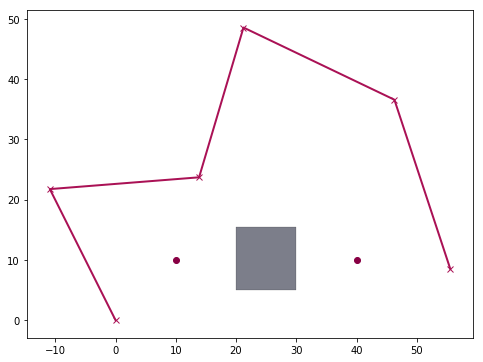

In [195]:
mapa1 = Mapa(wp_ori, wp_des, [verts1])

ag = Genetic(Subject, mapa1)

best = ag.run()

plot_map(
    [verts1], 
    ['n'], 
    wp_ori, 
    wp_des, 
    best.get_route(),
    None
)

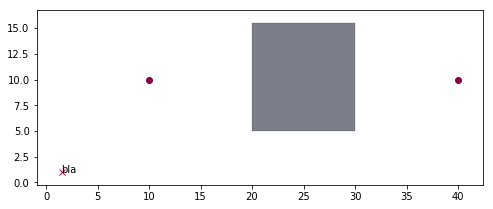

False

In [192]:
wp_ori = CartesianPoint(10.0, 10.0)
wp_des = CartesianPoint(40.0, 10.0)

verts1 = [
    (20.0, 5.0), # left, bottom
    (20.0, 15.5), # left, top
    (30.0, 15.5), # right, top
    (30.0, 5.0), # right, bottom
    (20.0, 5.0), # ignored
]
verts1 = [CartesianPoint(v[0], v[1]) for v in verts1]

plot_map(
    [verts1], 
    ['n'], 
    wp_ori, 
    wp_des, 
    [[1.5,1.0]],
    ['bla']
)

wp_inside = CartesianPoint(2.5, 1.0)
#point_in_polygon(wp_ori, verts1)
point_in_polygon(wp_inside, verts1)

In [169]:
# TODO: Melhorar

class Mapa():
    def __init__(self, origin, destination, areas_n):
        self.origin = origin # CartesianPoint(origin[0], origin[1]) # (x, y)
        self.destination = destination # CartesianPoint(destination[0], destination[1]) # (x, y)
        self.areas_n = areas_n # [area, ...]
        
class Area():
    def __init__(self, vertices):
        self.vertices = vertices

## Ray Casting Algorithm

In [103]:
# Used on the Ray-Tracing Algorithm
epsilon = 0.00001 

def point_in_polygon(point, polygon):
    # Using ray_casting algorithm
    # https://rosettacode.org/wiki/Ray-casting_algorithm

    count = 0
    
    for i in range(len(polygon) - 1):
        vertex1 = polygon[i]
        vertex2 = polygon[i-1]

        if vertex1.y < vertex2.y:
            A = vertex1
            B = vertex2
        else:
            A = vertex2
            B = vertex1

        if ray_intersects_segment(point, A, B):
            count += 1

    if count % 2 == 0: # Odd
        return False 
    else:
        return True # Inside the polygon
    
    

def ray_intersects_segment(P, A, B):
    # P : the point from which the ray starts
    # A : the end-point of the segment with the smallest y coordinate
    #     (A must be "below" B)
    # B : the end-point of the segment with the greatest y coordinate
    #     (B must be "above" A)

    # To avoid the "ray on vertex" problem, the point is moved upward of a small quantity epsilon.
    if P.y == A.y or P.y == B.y:
        P.y += epsilon

    # Point higher or lower than polygon
    if P.y < A.y or P.y > B.y:
        return False

    # Point to the right of the polygon
    elif P.x >= max(A.x, B.x):
        return False 

    else:

        if P.x < min(A.x, B.x):
            return True

        else:

            if A.x != B.x:
                m_red = (B.y - A.y)/(B.x - A.x)
            else:
                m_red = 99999999 # Infinite


            if A.x != P.x:
                m_blue = (P.y - A.y)/(P.x - A.x)
            else:
                m_blue = 99999999 # Infinite


            if m_blue >= m_red:
                return True
            else:
                return False

TODO: gerar pontos aleatorios e plotar a label dizendo se o ponto está dentro do poligono ou não

### Ray Casting Algorithm Stress Test

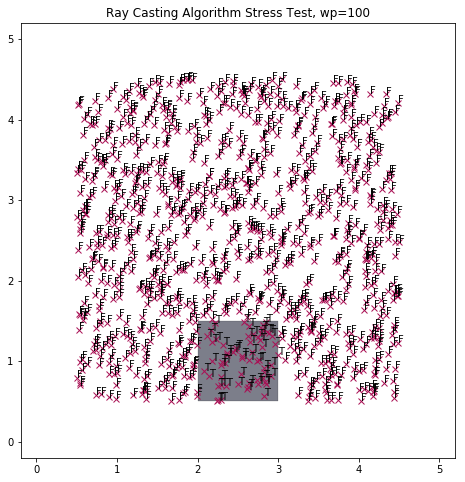

In [105]:
qty_points = 1000


verts1 = [
    (2.0, 0.5), # left, bottom
    (2.0, 1.5), # left, top
    (3.0, 1.5), # right, top
    (3.0, 0.5), # right, bottom
    (2.0, 0.5), # ignored
]
verts1 = [CartesianPoint(v[0], v[1]) for v in verts1]

texts = []
wps = []
for i in range(qty_points):
    x = random.uniform(0.5,4.5)
    y = random.uniform(0.5,4.5)
    
    wp = CartesianPoint(x,y)
    wps.append(wp)
    texts.append(str(point_in_polygon(wp, verts1))[0])
    
plot_map(
    [verts1], 
    ['n'], 
    None, 
    None, 
    wps,
    texts,
    wp_style='x',
    title='Ray Casting Algorithm Stress Test, wp=100'
)

    

## Visualization

In [106]:
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches

In [107]:
cor_area_nn    = '#25283d' # Yankees Blue
cor_area_p     = '#8f3985' # Plum
cor_area_b     = '#07beb8' # Tiffany Blue
cor_waypoints  = '#aa1155' # Jazzberry Jam
cor_ori_dest   = '#880044' # Pink Raspberry

In [108]:
def new_shape(vertices, color='navajowhite', lw=.25):

    assert len(vertices) >= 3, 'At least 3 vertices to form a shape'

    colors = {
        'n': cor_area_nn,
        'p': cor_area_p,
        'b': cor_area_b
    }
    
    color = colors[color] if color in colors else color
    
    codes = [Path.MOVETO]
    for i in range(1, len(vertices)-1):
        codes.append(Path.LINETO)
    codes.append(Path.CLOSEPOLY)
    
    path = Path(vertices, codes)

    patch = patches.PathPatch(path, facecolor=color, lw=lw, alpha=0.6)

    return patch




def plot_map(areas, labels, origem, destino, waypoints, texts, wp_style='-x', **kwargs):

    fig, ax = plt.subplots(figsize=(8,8)) 
    
    # Plot areas
    if areas and labels:
        patches = [ new_shape(vertice, color=label) for vertice, label in zip(areas, labels) ]
        for patch in patches:
            ax.add_patch(patch)
        
    # Plot origin and destination
    if origem and destino:
        ax.plot([origem[0], destino[0]], [origem[1], destino[1]], 'o', color=cor_ori_dest)
    
    # Plot waypoints and route
    if waypoints:
        waypoints = list(map(list, zip(*waypoints)))
        ax.plot(waypoints[0], waypoints[1], wp_style, color=cor_waypoints, linewidth=2) #marker='x', linestyle='solid'
        if texts:
            for i, text in enumerate(texts):
                ax.annotate(text, (waypoints[0][i], waypoints[1][i]))
    
    # Set size
    automin, automax = ax.get_xlim()
    plt.xlim(automin-0.5, automax+0.5)
    automin, automax = ax.get_ylim()
    plt.ylim(automin-0.5, automax+0.5)
    plt.gca().set_aspect('equal', adjustable='box')
    
    if 'title' in kwargs:
        plt.title(kwargs['title'])
    
    plt.show()
    
